<a href="https://colab.research.google.com/github/leshcsr/IA_imageRecognition/blob/main/IA_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conexión con google drive para acceder al dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/"
!ls

/content/drive/MyDrive
 checkpoints		   Dataset		        paragraphs
 checkpoint.weights.h5	  'Documento sin título.gdoc'   texts
'Colab Notebooks'	   exportedModels	        training_history.pkl
 Conplag_version_Dataset  'FINAL MIGRACIÓN'


Importar las librerías necesarias

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D, Dropout, BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score

# Preprocesamiento

Indicamos donde se encuentran las imagenes que conforman el data set. En este caso, las tenemos en la Carpeta base "Dataset", dentro de ella, se encuentran otros 2 directorios, "train" y "test".

In [4]:
base_dir = 'Dataset'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

Posteriormente, aplicamos las técnicas de escalamiento y data augmentation en los datos de train y test. Para el escalamiento se aplica la normalización.

In [5]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 10,
							width_shift_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True)

test_datagen = ImageDataGenerator(
							rescale = 1./255)

validation_datagen = ImageDataGenerator(
							rescale = 1./255)

Definimos un tamaño estandar para las imagenes y el tamaño del bach que usaremos posteriormente cargar las imagenes desde el directorio, con los generadores de antes.

In [6]:
batch_size = 32
input_shape = (120, 120, 3)
num_classes = 8
img_size = (120, 120)

Carga de las imágenes,

In [7]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = img_size,
							batch_size = batch_size,
							class_mode ='categorical',
							)

test_generator = test_datagen.flow_from_directory(
              test_dir,
              target_size=img_size,
              batch_size=batch_size,
              class_mode='categorical',
              )

validation_generator = validation_datagen.flow_from_directory(
              validation_dir,
              target_size=img_size,
              batch_size=batch_size,
              class_mode='categorical',
              )

Found 2655 images belonging to 8 classes.
Found 656 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


<Figure size 640x480 with 0 Axes>

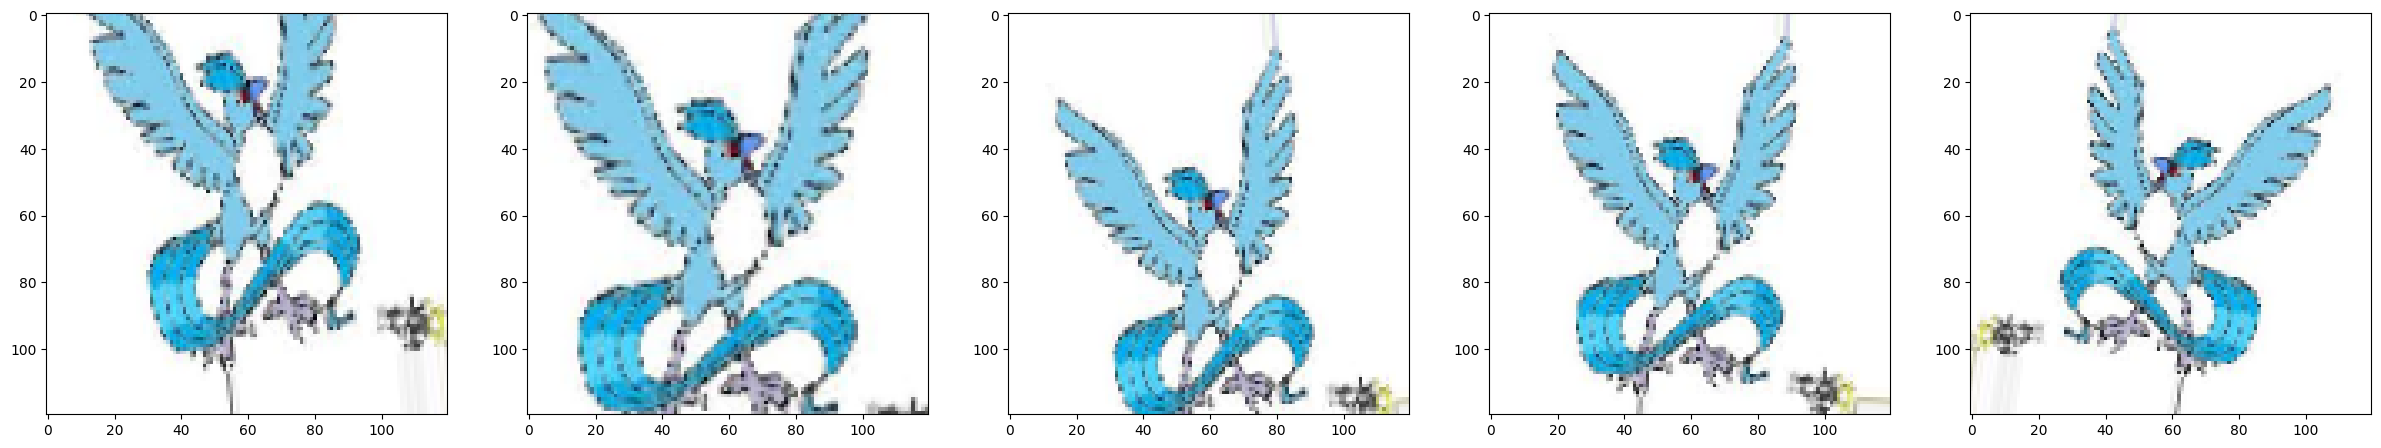

In [8]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5) :
  axarr[i].imshow(train_generator[1][0][0])

In [9]:
class_names = train_generator.class_indices.keys()
class_names

dict_keys(['Abra', 'Aerodactyl', 'Arbok', 'Articuno', 'Bulbasaur', 'Cubone', 'Diglett', 'Ditto'])

In [14]:
class BasicBlock(tf.keras.Model):
    def __init__(self, filters, stride=1, downsample=False):
        super(BasicBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.downsample = downsample
        if downsample:
            self.downsample_layer = tf.keras.Sequential([
                layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False),
                layers.BatchNormalization()
            ])

    def call(self, x, training=False):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        if self.downsample:
            identity = self.downsample_layer(x, training=training)

        out += identity
        out = self.relu(out)
        return out

In [15]:
def make_layer(filters, blocks, stride):
    layers_list = []
    layers_list.append(BasicBlock(filters, stride=stride, downsample=(stride != 1)))
    for _ in range(1, blocks):
        layers_list.append(BasicBlock(filters))
    return tf.keras.Sequential(layers_list)

def build_resnet(input_shape=(120, 120, 3), num_classes=8):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = make_layer(64, 2, stride=1)(x)
    x = layers.Dropout(0.25)(x)
    x = make_layer(128, 2, stride=2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model = Sequential([
    Conv2D(10, (3,3), activation='relu', input_shape=(120, 120, 3)),
    MaxPooling2D(2,2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Flatten(),
    Dense(8, activation='softmax')
])

In [11]:
model = build_resnet(input_shape=input_shape, num_classes=num_classes)

NameError: name 'build_resnet' is not defined

In [13]:
model.compile(optimizer=   'adam',
              loss=   "categorical_crossentropy",
              metrics =  ['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 118, 118, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 59, 59, 128)    │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 59, 59, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 445568)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │     3,564,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,582,752 (13.67 MB)

 Trainable params: 3,582,752 (13.67 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
checkpoint_path = "/content/drive/MyDrive/checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq="epoch",
                             save_weights_only=True,
                             verbose=1)

In [55]:
#El que tarda 3 hrs
class TestPerformanceCallback(Callback):
    def __init__(self, test_generator):
        super(TestPerformanceCallback, self).__init__()
        self.test_generator = test_generator
        self.test_loss = []
        self.test_accuracy = []
        self.test_f1 = []


    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for batch_x, batch_y in self.test_generator:
            y_true_batch = np.argmax(batch_y, axis=1)
            y_pred_batch = np.argmax(self.model.predict(batch_x, verbose=0), axis=1)

            y_true.extend(y_true_batch)
            y_pred.extend(y_pred_batch)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Métricas
        loss, acc = self.model.evaluate(self.test_generator, verbose=0)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        # Guardar
        self.test_loss.append(loss)
        self.test_accuracy.append(acc)
        self.test_f1.append(f1)

        # Mostrar
        print(f"Epoch {epoch + 1}: Test loss = {loss:.4f}, accuracy = {acc:.4f}, F1 = {f1:.4f}")


In [17]:
checkpoint_path = "/content/drive/MyDrive/checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq="epoch",
                             save_weights_only=True,
                             verbose=1)

class TestPerformanceCallback(Callback):
    def __init__(self, test_generator):
        super(TestPerformanceCallback, self).__init__()
        self.test_generator = test_generator
        self.test_loss = []
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_generator, verbose=0)
        self.test_loss.append(loss)
        self.test_accuracy.append(acc)
        print(f"Epoch {epoch + 1}: Test loss = {loss:.4f}, Test accuracy = {acc:.4f}")


In [18]:
test_callback = TestPerformanceCallback(test_generator)

In [19]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, test_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1678 - loss: 2.3302
Epoch 1: saving model to /content/drive/MyDrive/checkpoint.weights.h5
Epoch 1: Test loss = 1.6568, Test accuracy = 0.3277
83/83 ━━━━━━━━━━━━━━━━━━━━ 1023s 12s/step - accuracy: 0.1685 - loss: 2.3267 - val_accuracy: 0.3969 - val_loss: 1.5881
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3781 - loss: 1.6837
Epoch 2: saving model to /content/drive/MyDrive/checkpoint.weights.h5
Epoch 2: Test loss = 1.3193, Test accuracy = 0.5488
83/83 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.3787 - loss: 1.6826 - val_accuracy: 0.5437 - val_loss: 1.2212
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5262 - loss: 1.3825
Epoch 3: saving model to /content/drive/MyDrive/checkpoint.weights.h5
Epoch 3: Test loss = 0.8906, Test accuracy = 0.6997
83/83 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5267 - loss: 1.3815 - val_accuracy: 0.7594 - val_loss: 0.8136
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━

In [20]:
! ls -lh checkpoints

total 321M
-rw------- 1 root root 321M May 26 07:03 checkpoint.weights.h5


In [ ]:
model.load_weights(checkpoint_path)

In [21]:
test_loss, test_acc = model.evaluate(test_generator)
print('\nTest accuracy:', test_acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.8323 - loss: 0.5471

Test accuracy: 0.8368902206420898


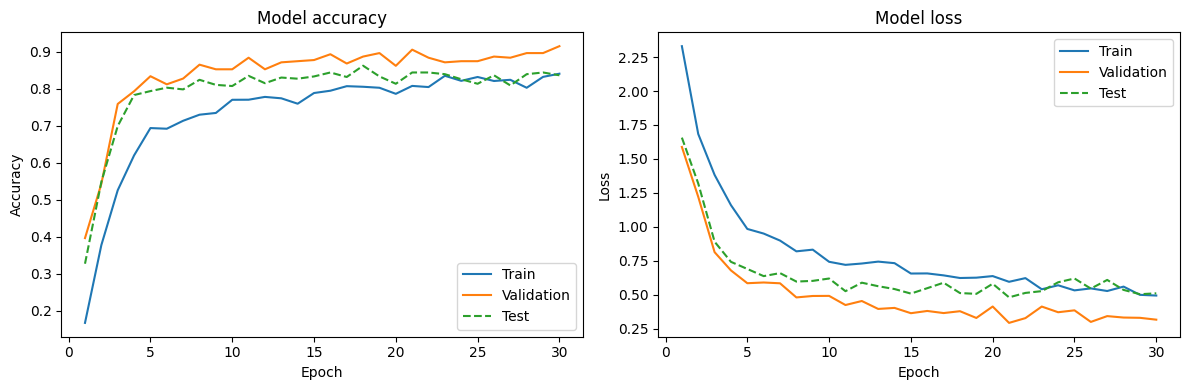

In [28]:
import matplotlib.pyplot as plt

# Métricas por época extraídas del log
epochs = list(range(1, 31))

train_accuracy = [
    0.1678, 0.3781, 0.5262, 0.6204, 0.6943, 0.6925, 0.7140, 0.7304, 0.7351, 0.7707,
    0.7709, 0.7785, 0.7747, 0.7601, 0.7890, 0.7952, 0.8075, 0.8059, 0.8032, 0.7868,
    0.8082, 0.8051, 0.8356, 0.8219, 0.8323, 0.8215, 0.8247, 0.8032, 0.8326, 0.8412
]

val_accuracy = [
    0.3969, 0.5437, 0.7594, 0.7937, 0.8344, 0.8125, 0.8281, 0.8656, 0.8531, 0.8531,
    0.8844, 0.8531, 0.8719, 0.8750, 0.8781, 0.8938, 0.8687, 0.8875, 0.8969, 0.8625,
    0.9062, 0.8844, 0.8719, 0.8750, 0.8750, 0.8875, 0.8844, 0.8969, 0.8969, 0.9156
]

test_accuracy = [
    0.3277, 0.5488, 0.6997, 0.7835, 0.7942, 0.8034, 0.7988, 0.8247, 0.8110, 0.8079,
    0.8354, 0.8155, 0.8308, 0.8277, 0.8338, 0.8445, 0.8323, 0.8628, 0.8338, 0.8140,
    0.8445, 0.8445, 0.8399, 0.8262, 0.8140, 0.8369, 0.8095, 0.8399, 0.8445, 0.8369
]

train_loss = [
    2.3302, 1.6837, 1.3825, 1.1598, 0.9846, 0.9505, 0.8989, 0.8197, 0.8321, 0.7427,
    0.7202, 0.7300, 0.7440, 0.7326, 0.6563, 0.6571, 0.6427, 0.6234, 0.6258, 0.6375,
    0.5954, 0.6225, 0.5404, 0.5698, 0.5323, 0.5468, 0.5276, 0.5600, 0.4994, 0.4942
]

val_loss = [
    1.5881, 1.2212, 0.8136, 0.6793, 0.5850, 0.5903, 0.5844, 0.4804, 0.4910, 0.4917,
    0.4244, 0.4540, 0.3957, 0.4032, 0.3642, 0.3807, 0.3652, 0.3789, 0.3292, 0.4134,
    0.2929, 0.3280, 0.4131, 0.3713, 0.3853, 0.3001, 0.3428, 0.3322, 0.3302, 0.3166
]

test_loss = [
    1.6568, 1.3193, 0.8906, 0.7423, 0.6900, 0.6372, 0.6595, 0.5971, 0.6022, 0.6196,
    0.5263, 0.5889, 0.5629, 0.5420, 0.5086, 0.5484, 0.5887, 0.5125, 0.5067, 0.5811,
    0.4810, 0.5135, 0.5267, 0.5918, 0.6198, 0.5453, 0.6092, 0.5357, 0.5041, 0.5105
]

# === Graficar precisión ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train')
plt.plot(epochs, val_accuracy, label='Validation')
plt.plot(epochs, test_accuracy, label='Test', linestyle='--')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# === Graficar loss ===
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, val_loss, label='Validation')
plt.plot(epochs, test_loss, label='Test', linestyle='--')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

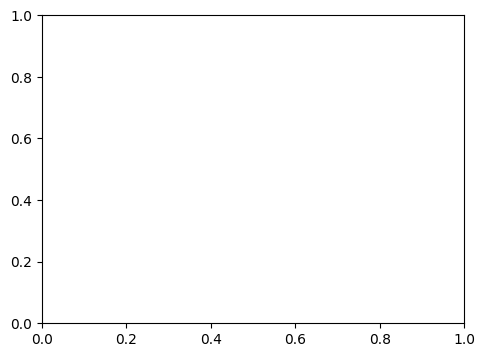

In [22]:
# Plot precisión de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(test_callback.test_accuracy, label='Test', linestyle='--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')

# Plot de la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(test_callback.test_loss, label='Test', linestyle='--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')

plt.show()

In [23]:
model.save('exportedModels/modelCNN1.h5')

In [24]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step


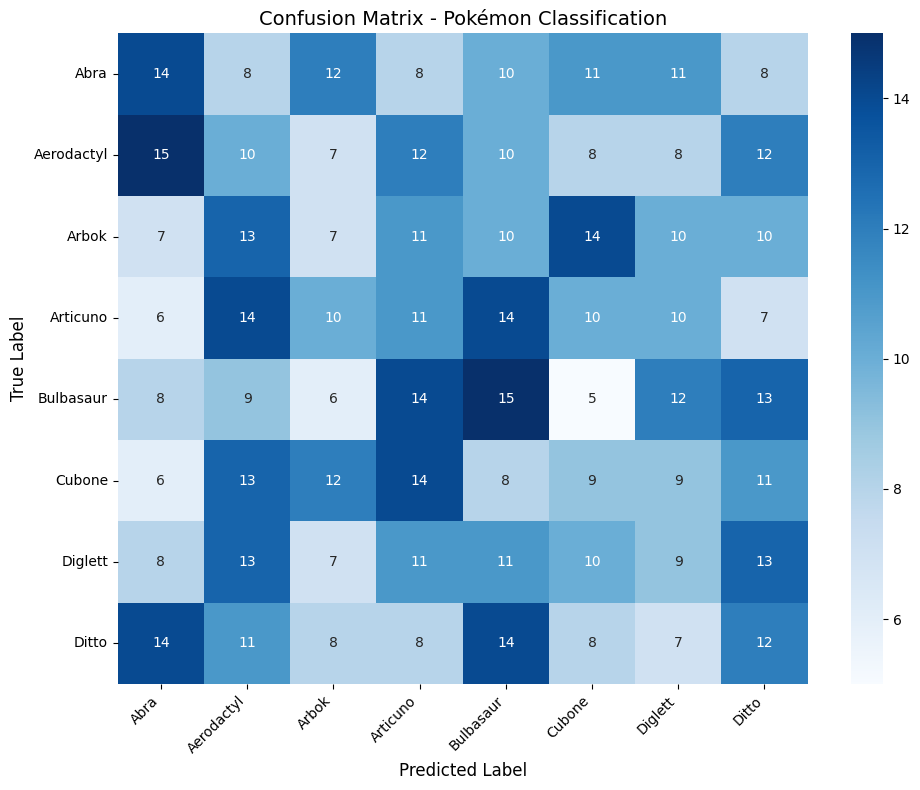

In [25]:
true_classes = test_generator.classes
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 10}
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Pokémon Classification', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

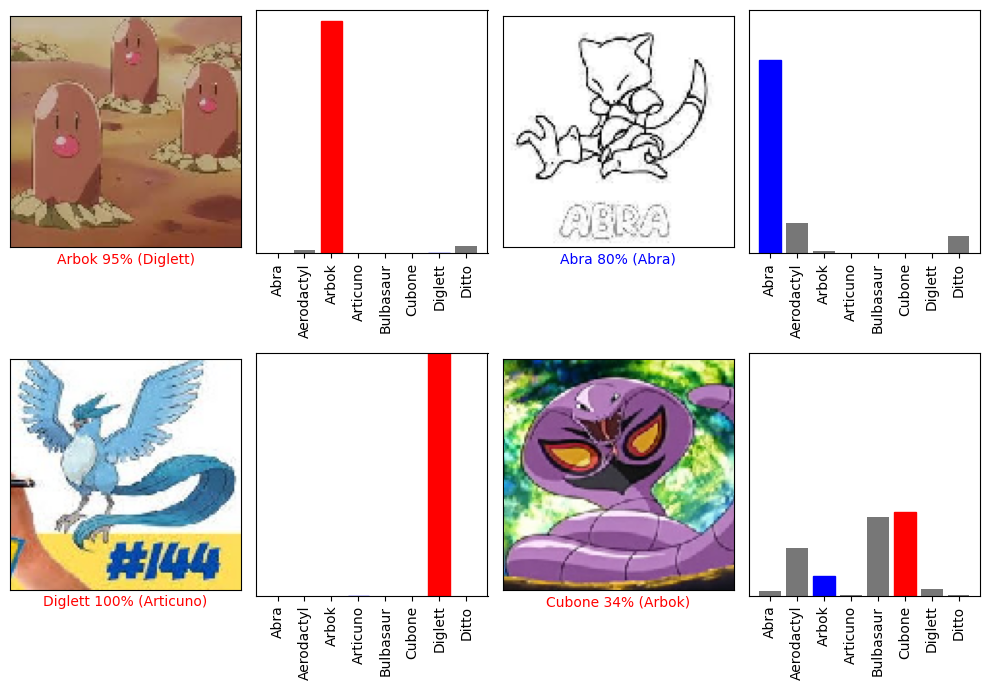

In [27]:
def plot_image(predictions_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    if img.max() > 1.0:
        plt.imshow(img.astype('uint8'))
    else:
        plt.imshow(img)

    true_label = np.argmax(true_label) if isinstance(true_label, (np.ndarray, list)) else true_label
    predicted_label = np.argmax(predictions_array)

    predicted_class = class_names[predicted_label]
    true_class = class_names[true_label]

    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel(f"{predicted_class} {100*np.max(predictions_array):2.0f}% ({true_class})",
              color=color)

def plot_value_array(predictions_array, true_label, class_names):
    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])

    true_label = np.argmax(true_label) if isinstance(true_label, (np.ndarray, list)) else true_label
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

class_names = list(train_generator.class_indices.keys())

# Obtener batch de test
test_images, test_labels = next(test_generator)

# Configurar gráficos
num_rows = 2
num_cols = 2
plt.figure(figsize=(10, 7))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(predictions[i], test_labels[i], test_images[i], class_names)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[i], test_labels[i], class_names)
plt.tight_layout()
plt.show()